# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [17]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI

In [10]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [5]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/ed/.cache/huggingface/token
Login successful


In [7]:
openai = OpenAI()

In [8]:
%matplotlib inline

In [9]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`TestRunner(my_prediction_function).run()`

To evaluate your model.

In [18]:
class TestRunner:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [19]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt}
    ]

In [20]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [21]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $209.95 Truth: $374.41 Error: $164.46 SLE: 0.33 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $74.99 Truth: $225.11 Error: $150.12 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.00 Truth: $61.68 Error: $11.68 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $450.00 Truth: $599.99 Error: $149.99 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $15.99 Truth: $16.99 Error: $1.00 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $129.99 Truth: $101.79 Error: $28.20 SLE: 0.06 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $450.00 Truth: $635.86 Error: $185.86 SLE: 0.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 I

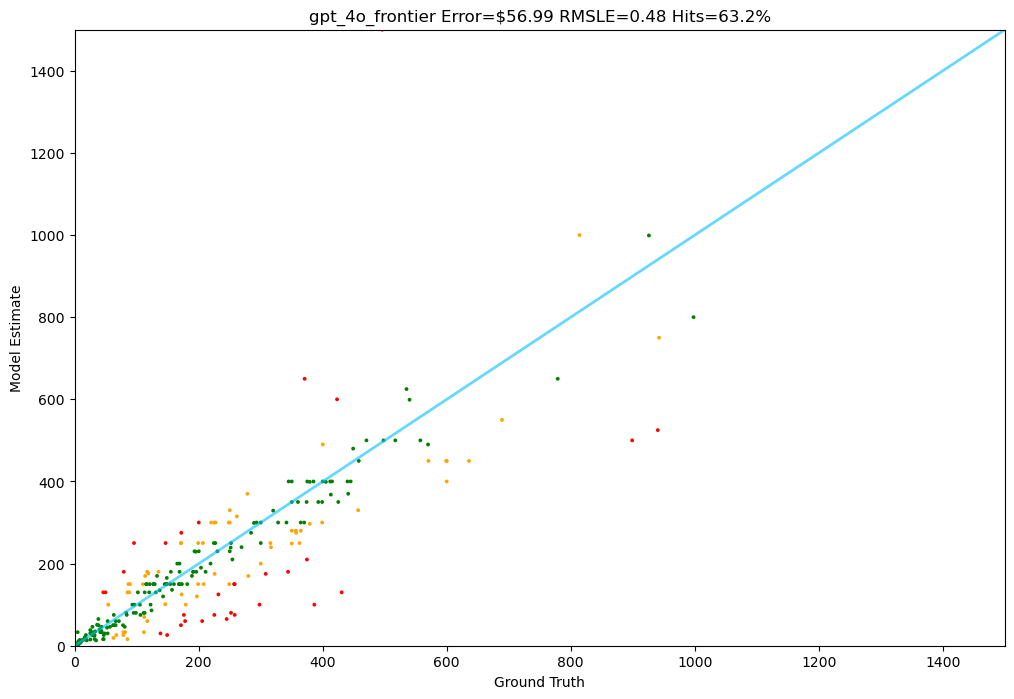

In [22]:
TestRunner(gpt_4o_frontier).run()

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

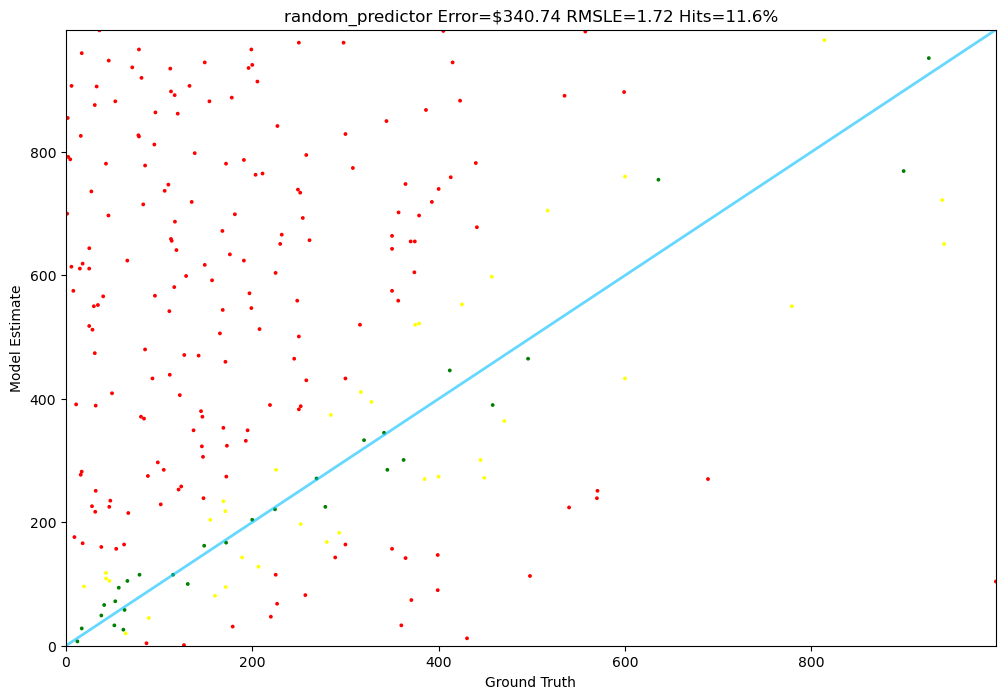

In [51]:
# Set the random seed

random.seed(42)

# Run our TestRunner

TestRunner(random_predictor).run()

In [52]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_predictor(prompt):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

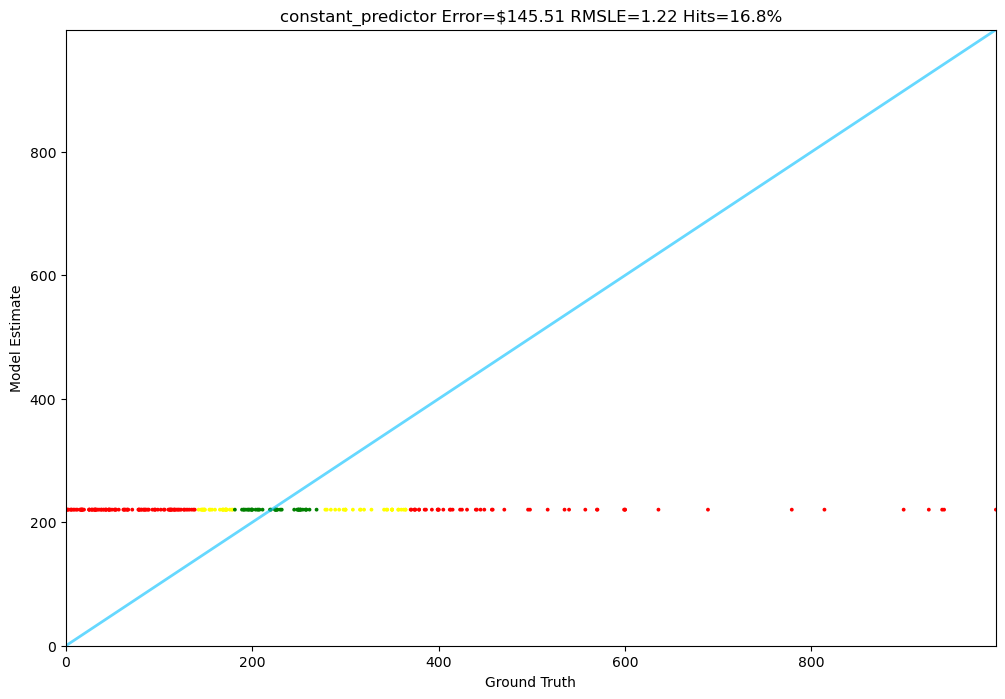

In [53]:
# Run our constant predictor

TestRunner(constant_predictor).run()

In [14]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [15]:
# Look at 20 most common features in training set

import json
feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1


In [16]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [17]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [18]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [19]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [20]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [21]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [22]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [23]:
def get_text_length(item):
    return len(item.test_prompt())

In [24]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

In [25]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [26]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [27]:
# Look at features in training ite,

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [29]:
np.random.seed(42)

# Separate features and target
feature_columns = [col for col in train_df.columns if col != 'price']
X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Print coefficients
for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


weight: 0.26423218629576695
rank: 5.197480233116636e-05
text_length: 0.007609328351322259
is_top_electronics_brand: 198.14254283207853
Intercept: 182.18661987897224
Mean Squared Error: 33034.336771967886
R-squared Score: 0.09091571194865511


In [30]:
# Function to predict price for a new item
def linear_regression_predictor(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $228.68 Truth: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $214.45 Truth: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $191.46 Truth: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.92 Truth: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.35 Truth: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.42 Truth: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.88 Truth: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.14 Truth: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.89 Truth: $635.86 Error: $414.97 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.88 Truth: $65.99 Error: $133.89 S

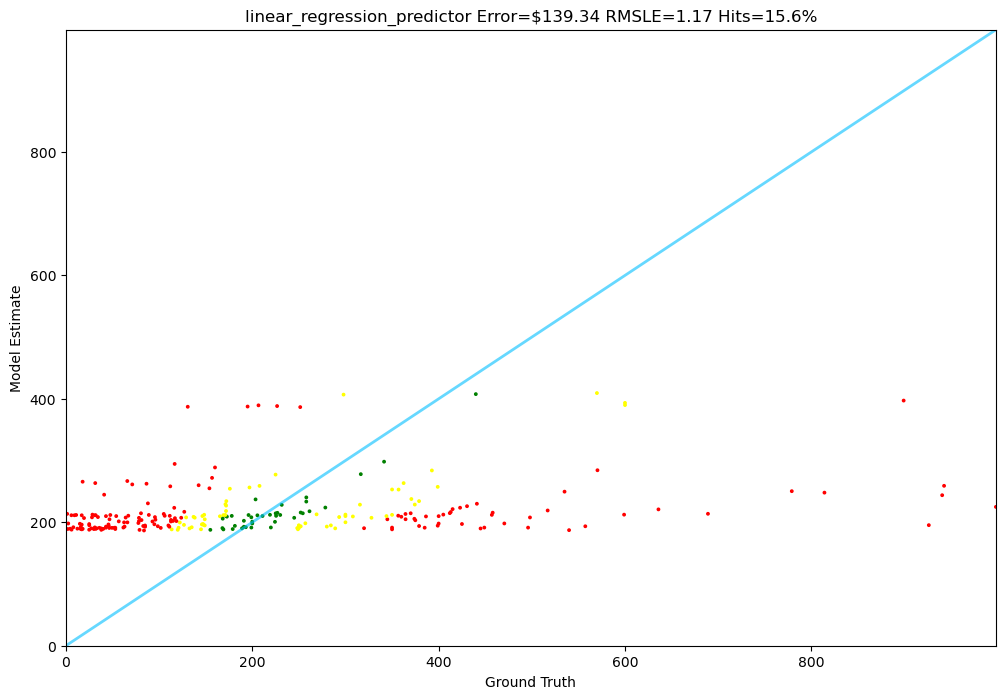

In [54]:
# test it

TestRunner(linear_regression_predictor).run()

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

np.random.seed(42)

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [34]:
def linear_regression_nlp_predictor(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.58 Truth: $374.41 Error: $77.83 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.14 Truth: $599.99 Error: $273.85 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.82 Truth: $101.79 Error: $243.03 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.56 Truth: $635.86 Error: $231.30 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.13 Truth: $65.99 Error: $45.14 SLE: 0

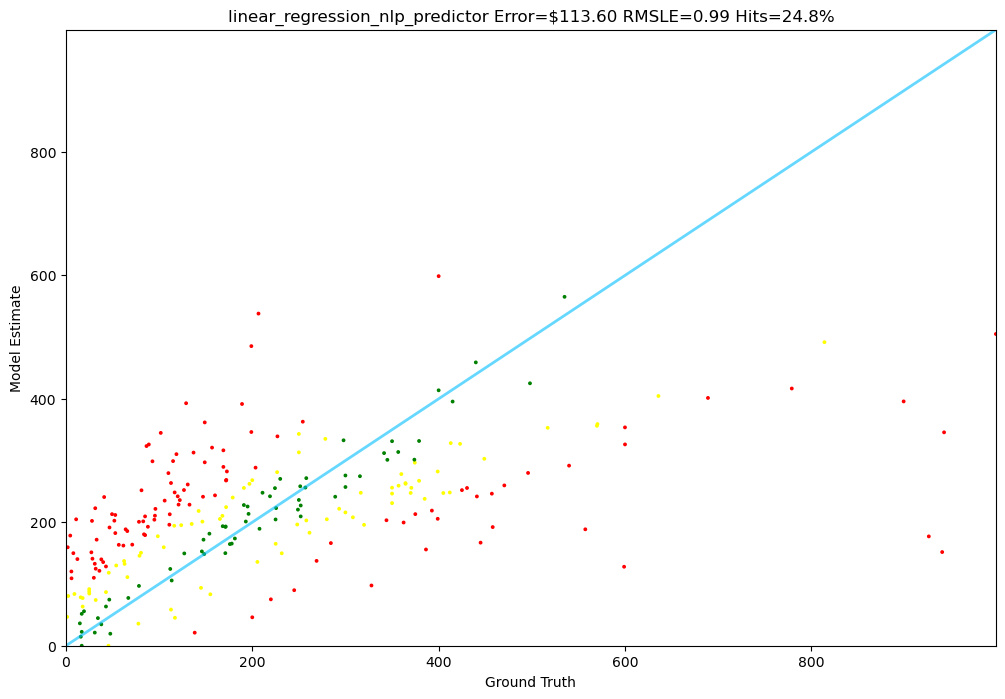

In [55]:
# test it
TestRunner(linear_regression_nlp_predictor).run()

In [70]:
import numpy as np
from sklearn.linear_model import LinearRegression
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=300, window=5, min_count=1, workers=8)

In [71]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X = np.array([document_vector(doc) for doc in documents])

In [38]:
word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X, prices)

LinearRegression()

In [56]:
def word2vec_lr_predictor(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $249.71 Truth: $374.41 Error: $124.70 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.39 Truth: $225.11 Error: $59.72 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $132.55 Truth: $61.68 Error: $70.87 SLE: 0.57 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $354.64 Truth: $599.99 Error: $245.35 SLE: 0.28 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $119.04 Truth: $16.99 Error: $102.05 SLE: 3.60 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $307.87 Truth: $101.79 Error: $206.08 SLE: 1.21 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $247.31 Truth: $289.00 Error: $41.69 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $346.95 Truth: $635.86 Error: $288.91 SLE: 0.37 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.51 Truth: $65.99 Error: $61.52 SLE:

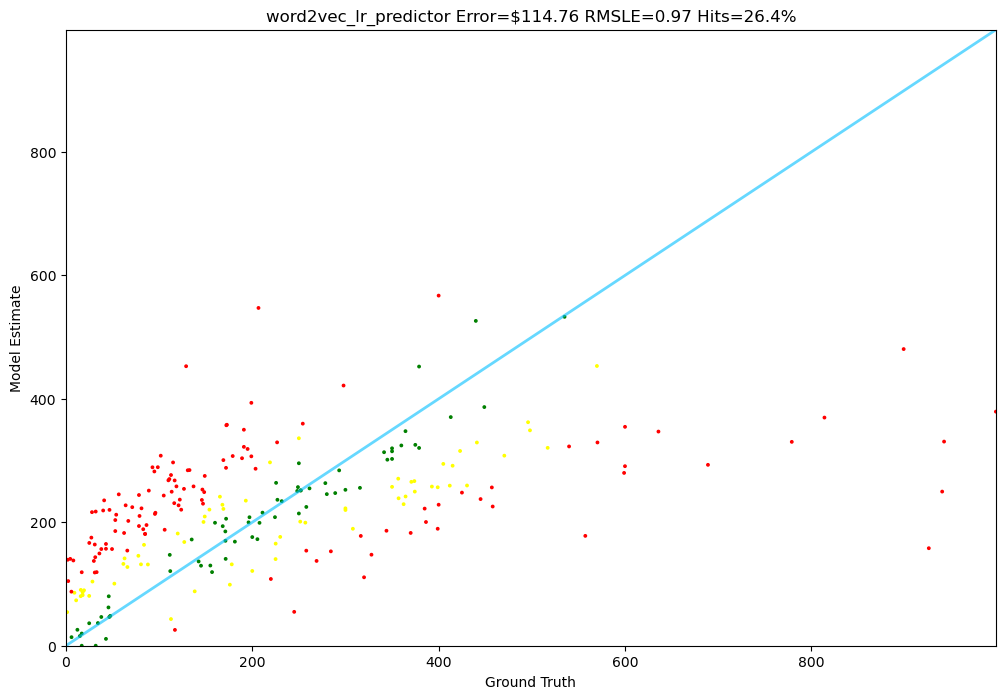

In [57]:
TestRunner(word2vec_lr_predictor).run()

In [72]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [73]:
def random_forest_predictor(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $320.73 Truth: $374.41 Error: $53.68 SLE: 0.02 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $197.62 Truth: $225.11 Error: $27.49 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $121.43 Truth: $61.68 Error: $59.75 SLE: 0.45 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $398.28 Truth: $599.99 Error: $201.71 SLE: 0.17 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $205.61 Truth: $16.99 Error: $188.62 SLE: 5.96 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $23.21 Truth: $31.99 Error: $8.78 SLE: 0.10 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $216.48 Truth: $101.79 Error: $114.69 SLE: 0.56 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $227.65 Truth: $289.00 Error: $61.35 SLE: 0.06 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $337.15 Truth: $635.86 Error: $298.71 SLE: 0.40 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $149.67 Truth: $65.99 Error: $83.68 SLE: 0

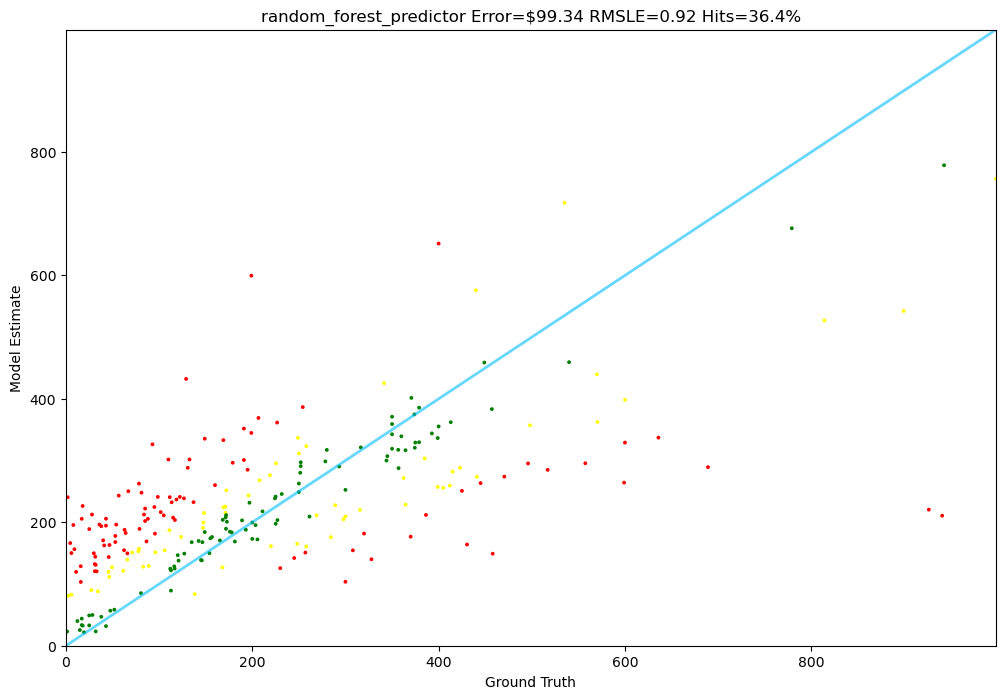

In [74]:
TestRunner(random_forest_predictor).run()

In [48]:
from sklearn.svm import SVR
np.random.seed(42)

svr_regressor = SVR(kernel='linear')
svr_regressor.fit(X[:100_000], prices[:100_000])

SVR(kernel='linear')

In [68]:
def svr_predictor(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $230.55 Truth: $374.41 Error: $143.86 SLE: 0.23 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $144.76 Truth: $225.11 Error: $80.35 SLE: 0.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $107.78 Truth: $61.68 Error: $46.10 SLE: 0.30 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $304.83 Truth: $599.99 Error: $295.16 SLE: 0.46 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $90.54 Truth: $16.99 Error: $73.55 SLE: 2.65 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $253.08 Truth: $101.79 Error: $151.29 SLE: 0.82 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $173.34 Truth: $289.00 Error: $115.66 SLE: 0.26 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $286.09 Truth: $635.86 Error: $349.77 SLE: 0.63 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.85 Truth: $65.99 Error: $45.86 SLE: 

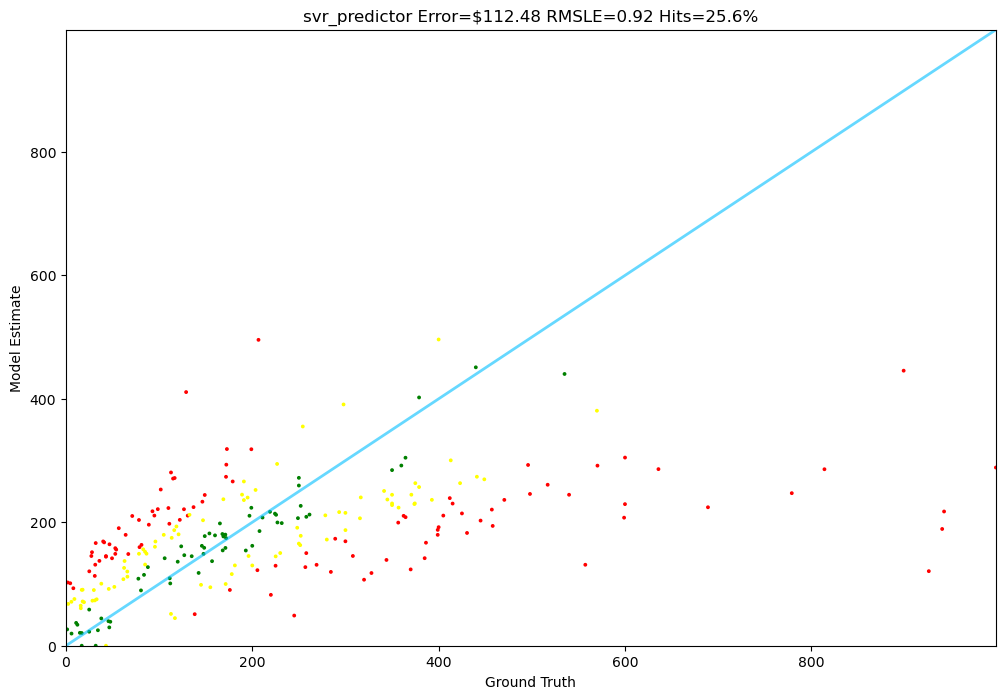

In [69]:
TestRunner(svr_predictor).run()